# 🧠 Predicting Scrabble Player Ratings

In **Scrabble Player Ratings** project, we'll unlock insights from gameplay data to predict player ratings using cutting-edge **deep learning regression** techniques. 🖥️✨

### 🗺️ What We'll Do:
1. **Explore the Data** 📊: Dive into the dataset and understand the patterns hidden within Scrabble games.
2. **Visualize Insights** 🌈: Create visualizations to make sense of the relationships and trends.
3. **Feature Engineering** 🛠️: Transform raw data into meaningful features to feed our deep learning model.
4. **Build the Model** 🤖: Design a powerful and complex deep learning architecture to predict player ratings with precision.
5. **Evaluate and Visualize Results** 🔍: Assess our model's performance and showcase results with informative plots.

### 📖 Dataset Source
This project utilizes data from [Kaggle's Scrabble Player Rating Competition](https://www.kaggle.com/competitions/scrabble-player-rating/overview), providing  gameplay information to train and evaluate our model.

# Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Importing and Preprocessing Dataset

In [23]:
train = pd.read_csv('/kaggle/input/scrabble-player-rating/train.csv')
games = pd.read_csv('/kaggle/input/scrabble-player-rating/games.csv')
turns = pd.read_csv('/kaggle/input/scrabble-player-rating/turns.csv')

In [24]:
#merging datasets on 'game_id'
train_merged = train.merge(games, on='game_id', how='left').merge(turns, on='game_id', how='left')

# Exploratory Data Analysis - EDA

In [4]:
train_merged.head()

,game_id,nickname_x,score_x,rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,...,max_overtime_minutes,game_duration_seconds,turn_number,nickname_y,rack,location,move,points,score_y,turn_type
0,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,...,1,674.844274,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,...,1,674.844274,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,...,1,674.844274,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,...,1,674.844274,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,...,1,674.844274,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


In [5]:
train_merged.shape

(2782578, 23)

In [6]:
train_merged.isnull().sum()

game_id                       0
nickname_x                    0
score_x                       0
rating                        0
first                         0
time_control_name             0
game_end_reason               0
winner                        0
created_at                    0
lexicon                       0
initial_time_seconds          0
increment_seconds             0
rating_mode                   0
max_overtime_minutes          0
game_duration_seconds         0
turn_number                   0
nickname_y                    0
rack                      96414
location                 177060
move                        590
points                        0
score_y                       0
turn_type                   506
dtype: int64

In [7]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782578 entries, 0 to 2782577
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   game_id                int64  
 1   nickname_x             object 
 2   score_x                int64  
 3   rating                 int64  
 4   first                  object 
 5   time_control_name      object 
 6   game_end_reason        object 
 7   winner                 int64  
 8   created_at             object 
 9   lexicon                object 
 10  initial_time_seconds   int64  
 11  increment_seconds      int64  
 12  rating_mode            object 
 13  max_overtime_minutes   int64  
 14  game_duration_seconds  float64
 15  turn_number            int64  
 16  nickname_y             object 
 17  rack                   object 
 18  location               object 
 19  move                   object 
 20  points                 int64  
 21  score_y                int64  
 22  turn_type         

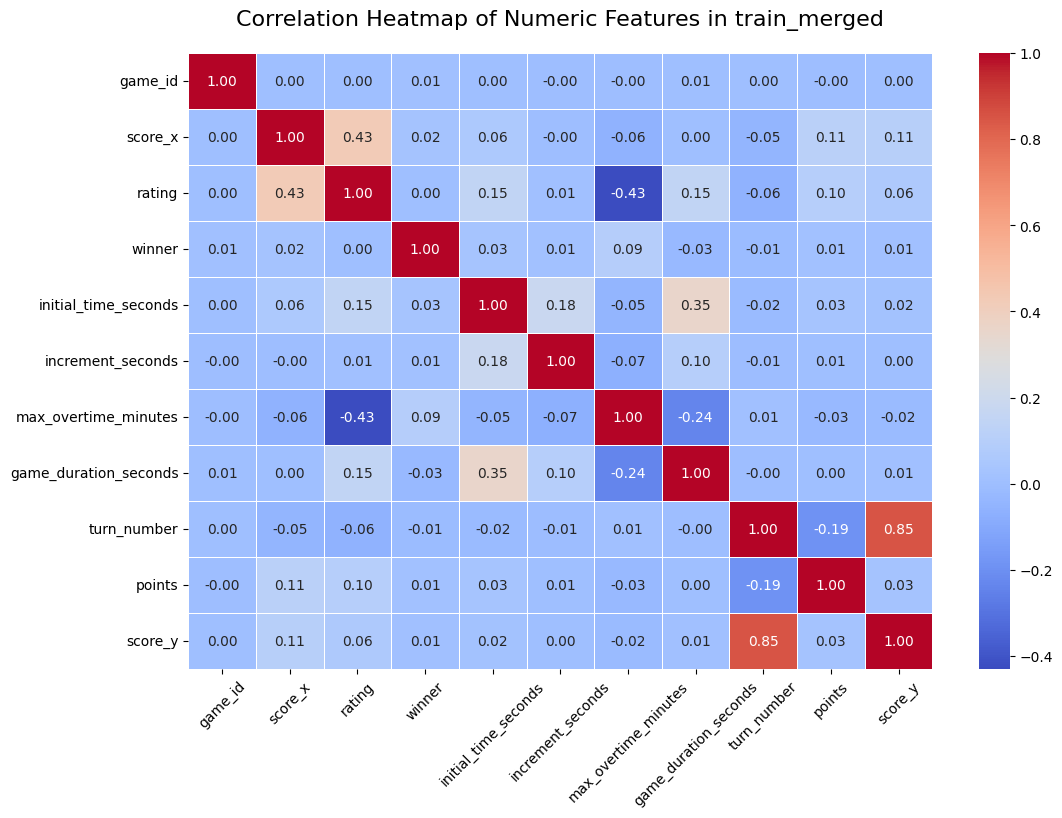

In [8]:
#correlation heatmap
numeric_columns = train_merged.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features in train_merged", fontsize=16, pad=20)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Feature Engineering

In [25]:
#filling missing values for  train_merged
train_merged['turn_type'] = train_merged['turn_type'].fillna("UNKNOWN")

In [26]:
#dropping the columns that are not used in model
train_merged.drop(['game_id', 'rack', 'location', 'move', 'nickname_x', 'nickname_y', 'created_at'], axis=1, inplace=True)

# Deep Learning Modelling with Sampling

In [11]:
#ensuring reproducibility
np.random.seed(42)

#one-hot encoding
categorical_cols = ['first', 'game_end_reason', 'rating_mode', 'turn_type', 'time_control_name','lexicon']
train_merged = pd.get_dummies(train_merged, columns=categorical_cols)

#stratified sampling 20% of data
sample_size = int(len(train_merged) * 0.2)
train_sampled, _ = train_test_split(train_merged, train_size=sample_size, stratify=train_merged['rating'], random_state=42)

#separating features and target variable for sampled data
train_features = train_sampled.drop(['rating'], axis=1)
train_target = train_sampled['rating']

In [12]:
#train-test split
x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.2, random_state=42)

#scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

#building the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

#compiling the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [13]:
#training the model on the sampled dataset
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=80, batch_size=64, verbose=0)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         121,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,757 (1.51 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 263,172 (1.00 MB)

In [15]:
#evaluating the model
val_predictions = model.predict(x_val).flatten()
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
r2 = r2_score(y_val, val_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

3479/3479 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
RMSE: 93.7168
R²: 0.8365


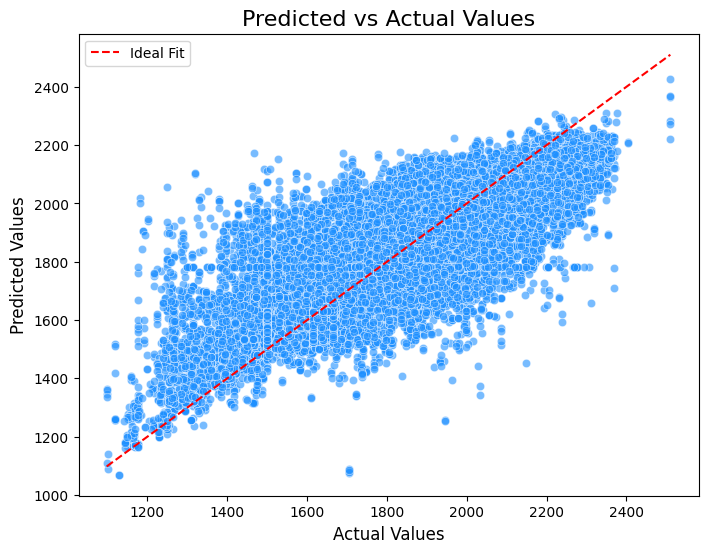

In [16]:
#predicted vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=val_predictions, alpha=0.6, color='dodgerblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', label='Ideal Fit')
plt.title("Predicted vs Actual Values", fontsize=16)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.show()

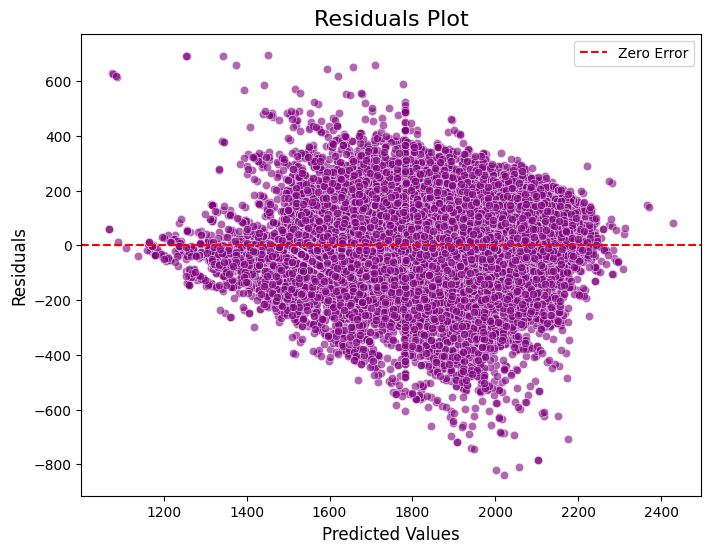

In [17]:
#residuals plot
residuals = y_val - val_predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=val_predictions, y=residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title("Residuals Plot", fontsize=16)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend()
plt.show()

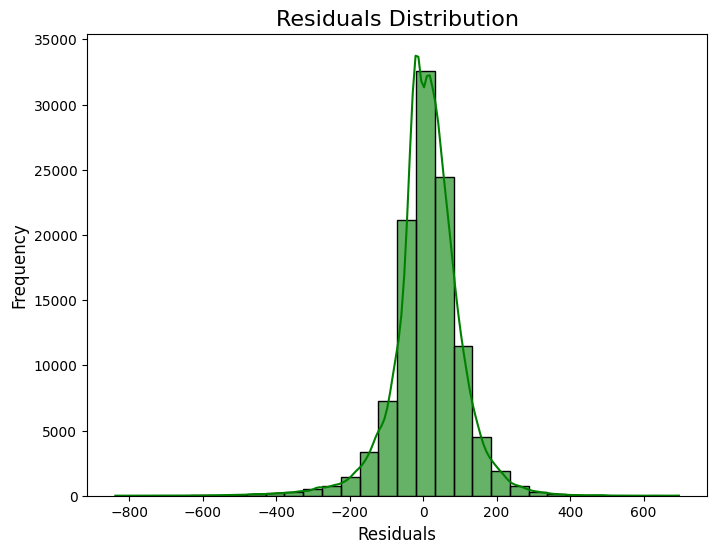

In [18]:
#residuals distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green', bins=30, alpha=0.6)
plt.title("Residuals Distribution", fontsize=16)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

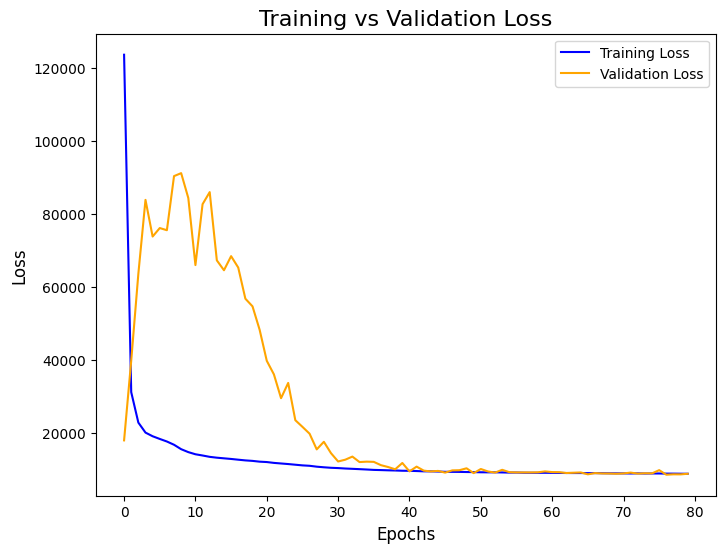

In [19]:
#training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()

# 🌟 Conclusion

In this project, we tackled the challenge of predicting **Scrabble Player Ratings** using gameplay data and deep learning techniques. 🧠✨ 

- **Data Exploration**: We thoroughly examined the dataset to uncover patterns and prepare it for modeling.
- **Feature Engineering**: Categorical features were one-hot encoded, while numerical features were scaled to enhance model performance.
- **Deep Learning Model**: A complex neural network was trained, utilizing dropout layers and early stopping to prevent overfitting. Given the size of the dataset, we utilized **20% stratified sampling** during training to ensure computational efficiency while maintaining the target variable's distribution.
- **Evaluation Metrics**: 
  - **RMSE**: ~90, showcasing a reasonable prediction accuracy for player ratings.
  - **R²**: Exceeded **0.80**, indicating a strong fit and explaining a significant proportion of variance in the target variable.
